# Evolving Ensembles in Multi-objective GeneticProgramming for Classification with Unbalanced Data

### Dataset YEAST

Minority class = 'MIT'

Majority class = other tags

In [1]:
# Python 3.8.3
import deap # 1.3.1
from deap import gp, creator, base, tools, algorithms
from deap import benchmarks
from deap.benchmarks.tools import hypervolume

import numpy as np # 1.18.5

import time

import operator, random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn import tree
# from sklearn.metrics import accuracy_score
from pandas import read_csv
# from sklearn.ensemble import RandomForestClassifier
#import graphviz

### Parameters

In [2]:
PNUM = 40 #20 # Number of individuals in a population (500)
GNUM = 20 #10 # Number of generations (50) 
MTC = 0.4 # Mutation chance (0.4)
CSC = 0.6 # Crossover chance (0.6)

ATR_DATA = 8 #Data set atributes

EPS = 0.1 # Range for protected division

#### Helper functions for primitive operators

In [3]:
# ovov je vracalo neki error kad sam probala dodat range
# def div(x, y): 
#     return x/y if y else 0

# Protected division
def div(x, y): 
    if(y < EPS and y > -EPS): return 0
    return x/y

# If then operator - changed the name from 'if_then' to 'lf' because of cxSemantic method
def lf(a, b, c):
    return b if (a < 0) else c

#### Importing dataset

In [4]:
filename = "./Datasets/yeast_csv.csv"
    
dataframe = read_csv(filename, header=None)

data = dataframe.values

# X = inputs, y = outputs
X, y = data[:, :-1], data[:, -1]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

data = X_train.tolist()

names = y_train.tolist()

(1484, 8)
(1484,)
(994, 8) (490, 8) (994,) (490,)


#### Creating a primitive set for the classificator expression

In [5]:
pset = gp.PrimitiveSet("main", arity=ATR_DATA)

# Adding primitive operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div, 2) 
pset.addPrimitive(lf, 3, name="lf") # Added 'lf' as a name for the function


# Generate an expression where each leaf has the same depth between min and max.
expr = gp.genHalfAndHalf(pset, min_=1, max_=8) # Create expression of max depth 8 (from paper)
tree = gp.PrimitiveTree(expr) # Create tree classificator from expression

### Creating a fitness function and an individual (Generation of Tree Individuals)

In [6]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0)) #FitnessMax, Multi, Min?

# Create an individual of type primitive tree and our fitness function, pset is a previously defined
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax, pset=pset)

### Helper function for evaluation

In [7]:
# Evaluation function
def evaluateAccuracy(individual, data, names, pset): # po predlosku
    
    #Compiling the expression
    classificator = gp.compile(individual, pset)
    
    minority_count = names.count("MIT")
    true_positive_count = 0
    
    majority_count = len(names) - minority_count
    true_negative_count = 0
    
    for (d, n) in zip(data, names):
        # feeding data to individual classificator
        result = classificator(*d)
        
        #counting right answers       
        if (n=="MIT") and (result >= 0): true_positive_count += 1
        elif (n!="MIT") and (result < 0): true_negative_count += 1
        
    # return accuracy on minority class and majority class
    return (true_positive_count/minority_count, true_negative_count/majority_count)

In [8]:
# Penalty function
def feasible(individual, data, names, pset):
    classificator = gp.compile(individual, pset)
    for (d, n) in zip(data, names):
        result = classificator(*d)
        if (n == "MIT"): return True
    return False

### Registering elements with toolbox

In [9]:
# Creating toolbox - https://deap.readthedocs.io/en/master/examples/gp_symbreg.html
# https://deap.readthedocs.io/en/master/tutorials/basic/part2.html
toolbox = base.Toolbox()

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=8) # genHalfAndHalf - Generate an expression with a PrimitiveSet pset. Half the time, the expression is generated with genGrow(), the other half, the expression is generated with genFull()
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr) # Register individual from expression

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#invalid_names = ['CYT', 'NUC', 'ME3', 'ME2', 'ME1', 'EXC', 'VAC', 'POX', 'ERL']

toolbox.register('evaluate', evaluateAccuracy, data=data, names=names, pset=pset)
# PENALTY - toolbox.decorate('evaluate', tools.DeltaPenalty(feasible, delta=invalid_names))

# Register mate function
toolbox.register('mate', gp.cxOnePoint)
#toolbox.register('mate', gp.cxSemantic, pset=pset, min=1, max=8)

#Register mutate function
toolbox.register('mutate', gp.mutNodeReplacement, pset=pset)
#toolbox.register('mutate', gp.mutSemantic, pset=pset, min=1, max=8)

#Preselect option
#toolbox.register('preselect', tools.selTournamentDCD)
#toolbox.register('preselect', tools.selRandom)

#Register select function
#toolbox.register('select', tools.selSPEA2)
toolbox.register('select', tools.selNSGA2)

#### Some possible needed funcions

In [10]:
##DRAWING THE TREE###
#expr = toolbox.individual()
#nodes, edges, labels = gp.graph(expr)

### Graphviz Section ###
#import pygraphviz as pgv

#g = pgv.AGraph()
#g.add_nodes_from(nodes)
#g.add_edges_from(edges)
#g.layout(prog="dot")

#for i in nodes:
#    n = g.get_node(i)
#    n.attr["label"] = labels[i]

#g.draw("tree.pdf")

In [11]:
#history = tools.History()

# Decorate the variation operators
#toolbox.decorate("mate", history.decorator)
#toolbox.decorate("mutate", history.decorator)

In [12]:
# diversity function
#def crowdingDistance(ind, hofer):
#    dist = np.linalg.norm(np.array(ind1.fitness.values) - np.array(ind2.fitness.values))
#    return True if(dist > 0.3) else False

    # if ind has bigger crowding distance than hoffer return false, else return true
    #eturn False if (dist > hofer)
    #return True
    
# def Ncl(ind, hofer):
    # if ind has bigger ncl return true, else return false (i think) (if ind gives more diverse answer than hofer return false, else return true)

### Generating population

In [13]:
# toolbox.population(n=PNUM)

population = toolbox.population(n=PNUM)

print(type(population))

#print(population.index())

fits = toolbox.map(toolbox.evaluate, population)
for fit, ind  in  zip(fits, population):
    ind.fitness.values = fit

#history.update(population)

<class 'list'>


### Setting stats and pareto front variable

In [14]:
# Diversity function

def similarFunc(ind1, ind2):
    if not isinstance(ind1, deap.creator.Individual):
        return False
    if not isinstance(ind2, deap.creator.Individual):
        return False
    if ind1 not in pop:
        return False
    if ind2 not in pop:
        return False

    ind1_pos = pop.index(ind1)
    ind2_pos = pop.index(ind2)
   
    if population[ind1_pos].fitness.crowding_dist == population[ind2_pos].fitness.crowding_dist:
        #print("IND1:", population[ind1_pos].fitness.crowding_dist)
        #print("IND2:", population[ind2_pos].fitness.crowding_dist)
        return True
    return False

In [15]:
pf = tools.ParetoFront(similar=similarFunc) #pareto front, can have diversity function as argument
#pf = tools.ParetoFront()

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


### Evolving the population 

In [16]:
#za sve vrijednosti
xvalues = []
yvalues = []
# #za posljednju generaciju 
# x_lastGen = []
# y_lastGen = []

start = time.time()

##DIVA-PORTAL##
"""
population = toolbox.select(population, len(population))
for gen in range(1, GNUM):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CSC, mutpb=MTC)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
        
        xvalues.append(ind.fitness.values[0])
        yvalues.append(ind.fitness.values[1])
        
#         if (gen == GNUM-1):
#             x_lastGen.append(ind.fitness.values[0])
#             y_lastGen.append(ind.fitness.values[1])
    
    population = toolbox.select(offspring + population, k=PNUM)
    pf.update(population)
"""
# This is just to assign the crowding distance to the individuals
# no actual selection is done
pop = toolbox.select(population, len(population))

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
    
# Begin the generational process
for gen in range(1, GNUM):
        # Vary the population
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]
        
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if random.random() <= CSC:
            toolbox.mate(ind1, ind2)
            
        toolbox.mutate(ind1)
        toolbox.mutate(ind2)
        
        xvalues.append(ind1.fitness.values[0]) # nisam sigurna dal se ovdje appenda za prikaz na grafu
        yvalues.append(ind1.fitness.values[1])
        xvalues.append(ind2.fitness.values[0])
        yvalues.append(ind2.fitness.values[1])
        
        del ind1.fitness.values, ind2.fitness.values
        
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

        # Select the next generation population
    pop = toolbox.select(pop + offspring, PNUM)
    pf.update(pop)

hv = hypervolume(pop, [11.0, 11.0]) # provjeriti za ovo, 11.0 i 11.0? 
#https://github.com/DEAP/deap/blob/master/deap/tools/_hypervolume/pyhv.py
print("Hypervolume: ", round(hv, 0))

stop = time.time()
print(f"Training time: {round(stop-start,2)}s")


Hypervolume:  144.0
Training time: 1.57s


### Printing and ploting the results

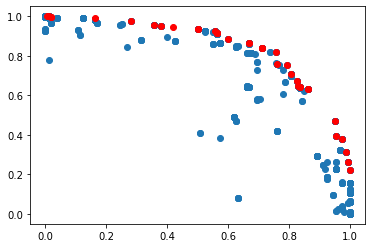

In [17]:
#zapisuje fitness vrijednosti od pareto fronte
px = []
py = []
for p in pf: 
    px.append(p.fitness.values[0])
    py.append(p.fitness.values[1])
    
# plotamo sve fitness vrijednosti i vrijednosti pareto fronte
plt.plot(xvalues, yvalues, 'o') #sve vrijednosti (plava boja)
#plt.plot(x_lastGen, y_lastGen, 'og') #vrijednosti zadnje generacije (zelena boja)
plt.plot(px, py, 'or') #pareto fronta (crvena boja)
plt.show()

In [18]:
#import matplotlib.pyplot as plt
#import networkx

# The History class helps to build a genealogy of all the individuals produced in the evolution. 
# It contains two attributes, the genealogy_tree that is a dictionary of lists indexed by individual, 
# the list contain the indices of the parents. The second attribute genealogy_history contains every 
# individual indexed by their individual number as in the genealogy tree.

#graph = networkx.DiGraph(history.genealogy_tree)
#graph = graph.reverse()     # Make the graph top-down
#colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
#networkx.draw(graph, node_color=colors)
#plt.show()

### Testing the population

In [19]:
def testEnsambleAccuracy (data, names, ensamble):
    
    minority_count = np.count_nonzero(names == "MIT")
    true_positive_count = 0
    
    majority_count = len(names) - minority_count
    true_negative_count = 0
    
    for d, n in zip(data, names):
        
        min_vote = 0;
        maj_vote = 0;
        
        for ind in ensamble:
            classificator = gp.compile(ind, pset)
            result = classificator(*d)
            
            if (result > 0): min_vote += 1
            elif (result < 0): maj_vote += 1
        
        if((n == "MIT") and (min_vote > maj_vote)): true_positive_count +=1;
        elif((n != "MIT") and (min_vote <= maj_vote)): true_negative_count += 1;
        
    return (true_positive_count/minority_count, true_negative_count/majority_count)

In [20]:
print(testEnsambleAccuracy(X_test, y_test, pf))

(0.5833333333333334, 0.9088669950738916)
